### Mixture models 
http://edwardlib.org/tutorials/unsupervised

http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/unsupervised.ipynb

http://edwardlib.org/api/ed/models/ParamMixture

http://edwardlib.org/api/ed/models/MultivariateNormalDiag

In [41]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Normal, Dirichlet, InverseGamma, ParamMixture, MultivariateNormalDiag, Empirical

In [4]:
# dimensions of the problem
D = 2      # feature space 
K = 2      # number of components
N = 500    # number of training samples

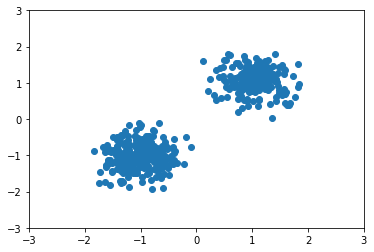

In [22]:
# generate training dataset
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

    return x

x_train = build_toy_dataset(N)

plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.show()

In [28]:
# setup priors
pi = Dirichlet(tf.ones(K))
mu = Normal(loc=tf.zeros(D), scale=tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(concentration=tf.ones(D), rate=tf.ones(D), sample_shape=K)

# setup mixture
'''
This distribution actually represents the conditional
distribution of the observable variable given a latent categorical
variable `cat` saying which mixture component generated this
distribution.
'''
x = ParamMixture(
    pi,                        # weights of mixture
    {                          # params for mixture components
        "loc": mu,
        "scale_diag": tf.sqrt(sigmasq)
    },                        
    MultivariateNormalDiag,     # components distribution 
    sample_shape=N
)

# latent variable (mixture component)
z = x.cat

In [29]:
# set up MCMC
T = 500                # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

(2,) (2,)
(2, 2) (2, 2)
(500,) (500,)


In [31]:
# run inference
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_train})
inference.initialize()

# initialize variables
sess = ed.get_session()
tf.global_variables_initializer().run()

# set a placeholder for running average
t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))

  5/500 [  1%]                                ETA: 488s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.05233609 -0.07601389]
 [-0.14162906 -0.14866218]]
 10/500 [  2%]                                ETA: 273s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.02646583 -0.02690042]
 [-0.19422761 -0.22065036]]
 15/500 [  3%]                                ETA: 190s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.02549018  0.04805977]
 [-0.26109716 -0.3119463 ]]
 20/500 [  4%] █                              ETA: 148s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.09049432  0.15237978]
 [-0.34633768 -0.40318087]]
 25/500 [  5%] █                              ETA: 122s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.16613384  0.2540206 ]
 [-0.41826543 -0.48419246]]
 30/500 [  6%] █                              ETA: 106s | Acceptance Rate: 1.000
Inferred cluster means:
[[ 0.24711399  0.34414226]
 [-0.4920738  -0.55683416]]
 35/500 [  7%] ██                       

In [39]:
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
clusters = tf.argmax(log_liks, 1).eval()

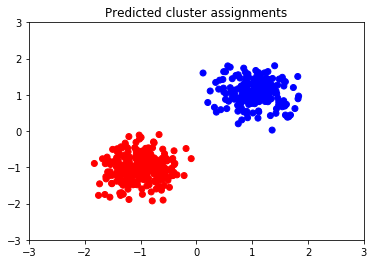

In [42]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()